# Cell Cycle Progressin (CCP) score 

<b>This code is for the Cell cycle (S,G2/M), cell cycle progression (CCP), hypoxia,  mesenchymal and epithelial score calculation.</b><br>
In this analysis I am calculating score for above pathways by using common biomarker genes.<br>
This is basic methodology for cell cycles score by using Seurat, but I am using my own code.
https://hbctraining.github.io/scRNA-seq/lessons/cell_cycle_scoring.html <br>
https://satijalab.org/seurat/reference/cc.genes.updated.2019.html#source <br>
<b> Cell cycle </b> genes :: https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv <br>
https://github.com/hbc/tinyatlas <br>
<b>Cell cycle progession (CCP) </b> score :: https://www.sciencedirect.com/science/article/pii/S1535610818305828?via%3Dihub<br>
<b>Hypoxia Biomaker</b> https:://www.sciencedirect.com/science/article/pii/S0936655515003118 <br>
<b>Stemness biomarker genes list </b>are available at www.pnas.org/cgi/doi/10.1073/pnas.1818210116 <br>

Omit genes below the median of average expression across samples Biranda et al. PNAS Stemness paper. At this point I didn't remove genes based on median expression cutoff. <br>
CCP manuscript also have Hypoxia score methodology, but I am not using that one.

### R libarary calling

In [1]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(limma)))
suppressMessages(suppressWarnings(library(GenomicFeatures)))

## Make gene information file for FPKM and FPKM-UQ calculation
R code to generate gene information file from GTF file. This gene information files is similar to TCGA. We will use this file for FPKM and FPKM-UQ calculation.

Length of genes is calculated by using all exons of genes, as in TCGA information file for FPKM/FPKM-UQ count calculation
https://www.biostars.org/p/185665/#9507426;  http://rseqc.sourceforge.net/#fpkm-uq-py

In [2]:
################ GRCm39 MM39 GENCODE annotation #####################

txdb <- makeTxDbFromGFF("Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz",format="gtf")
# then collect the exons per gene id
exons.list.per.gene <- exonsBy(txdb,by="gene")
# then for each gene, reduce all the exons to a set of non overlapping exons, calculate their lengths (widths) and sum then
exonic.gene.sizes <- sum(width(reduce(exons.list.per.gene)))
gene.exon.counts <- lengths(exons.list.per.gene)
gene.info <- cbind(exonic.gene.sizes, gene.exon.counts)
colnames(gene.info) <- c("exon_length", "exon_number")


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



In [3]:
gtf <- rtracklayer::import("Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz")
gencode.vM28.gtf <- as.data.frame(gtf)

gencode.vM28.gtf.selected <- gencode.vM28.gtf %>%
  filter(type=="gene") %>%
  dplyr::rename(Chr= seqnames, Type= type, Gene = gene_id, GeneType=gene_biotype, Symbol= gene_name, Length=width, Start = start, End=end, Strand=strand) %>%
  dplyr::select(Gene, Symbol,  Chr, Start, End, Strand,  GeneType, Length) #%>%
#filter(!grepl("chrM",Chr))

gene.lengths <- merge(gencode.vM28.gtf.selected, gene.info, by.x="Gene", by.y= "row.names")
head(gene.lengths)

,Gene,Symbol,Chr,Start,End,Strand,GeneType,Length,exon_length,exon_number
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3,108014596,108053462,-,protein_coding,38867,3262,9
2,ENSMUSG00000000003,Pbsn,X,76881507,76897229,-,protein_coding,15723,902,9
3,ENSMUSG00000000028,Cdc45,16,18599197,18630737,-,protein_coding,31541,3506,25
4,ENSMUSG00000000031,H19,7,142129266,142131880,-,lncRNA,2615,2460,20
5,ENSMUSG00000000037,Scml2,X,159865521,160041209,+,protein_coding,175689,6397,50
6,ENSMUSG00000000049,Apoh,11,108234180,108305222,+,protein_coding,71043,1594,16


## Calling gene expression data

In [318]:
#Exp <- read.table("blancgrp_211613_RNAseq_total_stranded_HTSeq.counts.raw.txt")
Exp <- read.table("blancgrp_211613_RNAseq_total_stranded.counts.raw.txt")
sampleTable <- factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3))
Exp <- as.data.frame(Exp)
head(Exp, 20)

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
rDNA_promoter,0,0,0,0,0,0,0,0,0
rDNA_promoter1,0,0,0,0,0,0,0,0,0
0610005C13Rik,1,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,0,0,0,0
0610009B22Rik,50,47,48,40,52,68,28,85,41
0610009E02Rik,8,7,6,2,2,4,3,4,3
0610009L18Rik,4,2,2,3,5,7,3,4,2
0610010F05Rik,134,100,101,98,187,193,71,113,124
0610010K14Rik,84,75,71,51,74,49,38,44,37


In [319]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(Exp)
sampleTable
head(gene.lengths)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


,Gene,Symbol,Chr,Start,End,Strand,GeneType,Length,exon_length,exon_number
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3,108014596,108053462,-,protein_coding,38867,3262,9
2,ENSMUSG00000000003,Pbsn,X,76881507,76897229,-,protein_coding,15723,902,9
3,ENSMUSG00000000028,Cdc45,16,18599197,18630737,-,protein_coding,31541,3506,25
4,ENSMUSG00000000031,H19,7,142129266,142131880,-,lncRNA,2615,2460,20
5,ENSMUSG00000000037,Scml2,X,159865521,160041209,+,protein_coding,175689,6397,50
6,ENSMUSG00000000049,Apoh,11,108234180,108305222,+,protein_coding,71043,1594,16


## FPKM and FPKM-UQ calculation part

In [320]:
GDC_FPKM <- function(mat, gene_lengths, method = "FPKM") 
{
    genes <- intersect(rownames(Exp), gene_lengths$Symbol)
    genes <- genes[-grep("_", genes)]
    
    gene_lengths <- gene_lengths[gene_lengths$Symbol %in% genes,]
    gene_lengths <- gene_lengths[!duplicated(gene_lengths$Symbol),]
    genes <- gene_lengths$Symbol
    mat <- as.matrix(Exp[genes,])
    RC_g  = mat[gene_lengths$Symbol,]
    #genes <- intersect(rownames(mat), gene_lengths$Symbol)
    
    protein_coding <- gene_lengths[grep("protein_coding", gene_lengths$GeneType),]$Symbol
    pc = mat[rownames(mat)%in%protein_coding,]
    RC_pc <- colSums(pc)
    
    eff_leng <- gene_lengths$exon_length
    names(eff_leng) <- gene_lengths$Symbol
    


    if (method == "FPKM") {
        fpkm <- do.call(cbind, lapply(1:ncol(RC_g), function(i) {
            (((RC_g[, i]) * 1e+09) / (eff_leng *RC_pc[i]))
        }))
        colnames(fpkm) <- colnames(RC_g)
        rownames(fpkm) <- rownames(RC_g)
        return(list(FPKM=fpkm, GeneLength=gene_lengths))}

    if(method=="FPKM-UQ") {
        uqs <- apply(pc, 2, quantile, 0.75)
        fpkm <- do.call(cbind, lapply(1:ncol(RC_g), function(i) {
            (((RC_g[, i]) * 1e+09) / (eff_leng * uqs[i]))
        }))
        colnames(fpkm) <- colnames(RC_g)
        rownames(fpkm) <- rownames(RC_g)
        return(list(FPKM_UQ=fpkm, GeneLength=gene_lengths))}
    
    if(method=="RAW"){
        return(list(HTSeqCounts=RC_g, GeneLength=gene_lengths))}
}

STAR_FPKM <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "FPKM")
STAR_FPKM_UQ <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "FPKM-UQ")
STAR_RAW <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "RAW")

In [321]:
dim(STAR_FPKM$FPKM)
dim(STAR_FPKM$GeneLength)
dim(STAR_FPKM_UQ$FPKM_UQ)
dim(STAR_FPKM_UQ$GeneLength)


[1] 52322     9

[1] 52322    10

[1] 52322     9

[1] 52322    10

## I will add extra part to make counts and lengths file for RPKM, TPM and CPM

In [322]:
################## Normalized read count matrix #####################
# https://gist.github.com/slowkow/6e34ccb4d1311b8fe62e
# https://www.reneshbedre.com/blog/expression_units.html
# This RPKM, TPM, CPM is same as Python 
rpkm <- function(counts, lengths) {
  rate <- (counts / lengths) * 1e9
  rate / sum(counts, na.rm = TRUE) }

tpm <- function(counts, lengths) {
  rate <- (counts / lengths)*1e3
  (rate / sum(rate, na.rm = TRUE)) * 1e6}

cpm <- function(counts, lengths)
{  (counts * 1e6) /sum(counts, na.rm = TRUE)}



## Biomarker genes list
### Cell Cycle Progession (CCP), G1-score, G1-M Score, EMT score

In [324]:
# https://hbctraining.github.io/scRNA-seq/lessons/cell_cycle_scoring.html
mouse.cell.cycle <- read.csv("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv")
# www.pnas.org/cgi/doi/10.1073/pnas.1818210116 #Stemness marker
#https://satijalab.org/seurat/reference/cc.genes.updated.2019.html#source
#Seurat::cc.genes.updated.2019
#median(colMeans(logcounts)) ## omit genes below the median of average expression across samples Biranda et al. PNAS Stemness paper
cc.S <- mouse.cell.cycle[mouse.cell.cycle$phase=="S",]
cc.G2 <- mouse.cell.cycle[mouse.cell.cycle$phase=="G2/M",]
CCP_gene <- stringr::str_to_sentence(c("PLK1", "RRM2", "CDCA8", "CDC20", "CDCA3", "FOXM1", "BIRC5", "PBK", "CDKN3", "CENPM", "MCM10", "TK1", "DTL", "ASF1B", "NUSAP1", "PRC1", "BUB1B", "DLGAP5", "TOP2A", "ASPM", "CENPF", "KIF20A", "PTTG1", "RAD54L", "ORC6", "CDK1", "CEP55", "KIF11", "RAD51", "KIAA0101", "SKA1"))
Housekeeping_gene <- stringr::str_to_sentence(c("RPL38", "UBA52", "PSMC1", "RPL4", "RPL37", "RPS29", "SLC25A3", "CLTC", "TXNL1", "PSMA1", "RPL8", "MMADHC", "RPL13A", "PPP2CA", "MRFAP1"))
Hypoxia_Gene <- stringr::str_to_sentence(c("BNIP3", "F3", "LOX", "TNF", "TH", "SLC2A1", "PGK1", "NDRG1", "GAL", "BNIP3L", "ANG", "P4HA1", "ADM", "AK3", "PDK1", "ERO1L", "ALDOC", "PLOD2", "P4HA2", "MXI1", "DDIT4", "ANGPTL4"))
Mesenchymal_Gene <- stringr::str_to_sentence(c("VIM", "CDH2", "FOXC2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGB6", "MMP2", "MMP3", "MMP9", "SOX10", "GCS"))
Epithelial_Gene <- stringr::str_to_sentence(c("CDH1", "DSP", "OCLN"))
STEM_Gene <- stringr::str_to_sentence(c("DNMT3B", "PFAS", "XRCC5", "HAUS6", "TET1", "IGF2BP1", "PLAA", "TEX10", "MSH6", "DLGAP5", "SKIV2L2", "SOHLH2", "RRAS2", "PAICS", "CPSF3", "LIN28B", "IPO5", "BMPR1A", "ZNF788", "ASCC3", "FANCB", "HMGA2", "TRIM24", "ORC1", "HDAC2", "HESX1", "INHBE", "MIS18A", "DCUN1D5", "MRPL3", "CENPH", "MYCN", "HAUS1", "GDF3", "TBCE", "RIOK2", "BCKDHB", "RAD1", "NREP", "ADH5", "PLRG1", "ROR1", "RAB3B", "DIAPH3", "GNL2", "FGF2", "NMNAT2", "KIF20A", "CENPI", "DDX1", "XXYLT1", "GPR176", "BBS9", "C14orf166", "BOD1", "CDC123", "SNRPD3", "FAM118B", "DPH3", "EIF2B3", "RPF2", "APLP1", "DACT1", "PDHB", "C14orf119", "DTD1", "SAMM50", "CCL26", "MED20", "UTP6", "RARS2", "ARMCX2", "RARS", "MTHFD2", "DHX15", "HTR7", "MTHFD1L", "ARMC9", "XPOT", "IARS", "HDX", "ACTRT3", "ERCC2", "TBC1D16", "GARS", "KIF7", "UBE2K", "SLC25A3", "ICMT", "UGGT2", "ATP11C", "SLC24A1", "EIF2AK4", "GPX8", "ALX1", "OSTC", "TRPC4", "HAS2", "FZD2", "TRNT1", "MMADHC", "SNX8", "CDH6", "HAT1", "SEC11A", "DIMT1", "TM2D2", "FST", "GBE1"))
Ribosome_Gene <- stringr::str_to_sentence(c("MYC", "HEATR1", "DNTTIP2", "DDX19B", "RPL3", "SUPT6H", "RPS28", "SUPT5H", "RPL19", "EIF4A3", "POLR2E", "DDX56", "RPS4X", "RPS6", "RPS8", "RPS3A", "RPS14", "NOL11", "RPS24", "WBP11", "RPS5", "RPS7", "MDN1", "RPS16", "ESF1", "RPL18", "RPL26", "RPL17", "RRN3", "RPS9", "RPLP2", "RPS13", "RPL8", "KIF11", "RPL35A", "RPL23A", "RPL24", "BCCIP", "RPL7", "RPS11", "NOP56", "UTP4", "RPS15A", "RPP30", "EXOSC9", "RIOX2", "RPS10", "NUMA1", "MPHOSPH10", "NSA2", "TRMT112", "RPS21", "NOP58", "UTP20", "RPUSD2", "RRS1", "NUDT16", "NOLC1", "NOL8", "METTL15", "SUV39H1", "XRCC5", "ABCE1", "TTF1", "MPV17L2", "MAF1", "POLR1D", "TAF1D"))

### Pathways score calculation

#### Select genes

In [325]:
Selected_Gene <- function(mat, geneLength){
    gene_lengths <- geneLength
    genes <- intersect(rownames(mat), gene_lengths$Symbol)
    gene_lengths <- as.data.frame(gene_lengths[gene_lengths$Symbol%in%genes,])
    mat <- as.data.frame(mat[genes,])
  return(list(Expression=mat, GeneLength=geneLength))}


#scale(log2(RSEM_FPKM+1), center = TRUE, scale = TRUE) ##https://medium.com/swlh/data-normalisation-with-r-6ef1d1947970
#exp.scaled <- (scale(log2(t(RSEM_FPKM+1)), center = TRUE, scale = TRUE))
#Selected_a <- Selected_Gene(mat = STAR_FPKM$FPKM, geneLength = STAR_FPKM$GeneLength)
Selected_a <- Selected_Gene(mat = STAR_RAW$HTSeqCounts, geneLength = STAR_RAW$GeneLength)

head(Selected_a$Expression, n=20)
head(Selected_a$GeneLength, n=10)

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Gnai3,562,474,492,330,611,631,285,513,405
Pbsn,0,0,0,0,0,0,0,0,0
Cdc45,136,97,129,69,119,116,46,67,51
H19,0,0,2,0,0,1,1,0,1
Scml2,0,0,1,0,0,0,0,1,0
Apoh,0,0,0,1,4,0,0,1,0
Narf,371,257,329,117,218,193,116,182,150
Cav2,672,569,638,227,429,539,268,496,347
Klf6,547,409,452,873,1353,1360,825,1241,1097


,Gene,Symbol,Chr,Start,End,Strand,GeneType,Length,exon_length,exon_number
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3,108014596,108053462,-,protein_coding,38867,3262,9
2,ENSMUSG00000000003,Pbsn,X,76881507,76897229,-,protein_coding,15723,902,9
3,ENSMUSG00000000028,Cdc45,16,18599197,18630737,-,protein_coding,31541,3506,25
4,ENSMUSG00000000031,H19,7,142129266,142131880,-,lncRNA,2615,2460,20
5,ENSMUSG00000000037,Scml2,X,159865521,160041209,+,protein_coding,175689,6397,50
6,ENSMUSG00000000049,Apoh,11,108234180,108305222,+,protein_coding,71043,1594,16
7,ENSMUSG00000000056,Narf,11,121128079,121146682,+,protein_coding,18604,4806,16
8,ENSMUSG00000000058,Cav2,6,17281184,17289114,+,protein_coding,7931,3335,7
9,ENSMUSG00000000078,Klf6,13,5911481,5920393,+,protein_coding,8913,4391,11


#### Calculate scores

In [326]:
S_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Gene %in% cc.S$geneID) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
G2M_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Gene %in% cc.G2$geneID) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
CCP <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% CCP_gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Housekeeping_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Housekeeping_gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Hypoxia_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Hypoxia_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Mesenchymal_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Mesenchymal_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Epithelial_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Epithelial_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Ribosome_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Ribosome_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)

Score_Total <- as.data.frame(t(rbind(S_Score, G2M_Score, CCP, Housekeeping_Score, Hypoxia_Score, Mesenchymal_Score, Epithelial_Score, Ribosome_Score)))
head(Score_Total)

,S_Score,G2M_Score,CCP,Housekeeping_Score,Hypoxia_Score,Mesenchymal_Score,Epithelial_Score,Ribosome_Score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,190,418.5,335.5,2563,97,0.5,3990,573
2,147,293.0,218.5,1803,80,0.0,2544,423
3,165,326.5,261.0,1998,80,0.0,2997,497
4,76,124.5,93.5,1438,23,3.5,1188,398
5,139,189.0,153.0,2301,60,10.5,1894,617
6,133,198.5,157.5,2444,65,9.5,2006,637


In [327]:
Mesenchymal_Score=Mesenchymal_Score-Housekeeping_Score
Epithelial_Score=Epithelial_Score-Housekeeping_Score
Score_Total <- Score_Total %>%
  dplyr::select(everything()) %>%
  mutate(EMT_Score=Mesenchymal_Score-Epithelial_Score, 
         CCP_Score=CCP-Housekeeping_Score, 
         S_Score=S_Score-Housekeeping_Score,
         G2M_Score=G2M_Score-Housekeeping_Score,
         Hypoxia_Score=Hypoxia_Score-Housekeeping_Score,
         Ribosome_Score=Ribosome_Score-Housekeeping_Score,
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  dplyr::select(c("Sample","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score", "Ribosome_Score"), everything())
head(Score_Total)

,Sample,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,Ribosome_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Control,-3989.5,-2227.5,-2373,-2144.5,-2466,-1990,335.5,2563,0.5,3990
2,Control,-2544.0,-1584.5,-1656,-1510.0,-1723,-1380,218.5,1803,0.0,2544
3,Control,-2997.0,-1737.0,-1833,-1671.5,-1918,-1501,261.0,1998,0.0,2997
4,TGFB,-1184.5,-1344.5,-1362,-1313.5,-1415,-1040,93.5,1438,3.5,1188
5,TGFB,-1883.5,-2148.0,-2162,-2112.0,-2241,-1684,153.0,2301,10.5,1894
6,TGFB,-1996.5,-2286.5,-2311,-2245.5,-2379,-1807,157.5,2444,9.5,2006


In [328]:
Mesenchymal_Score=Mesenchymal_Score-Housekeeping_Score
Epithelial_Score=Epithelial_Score-Housekeeping_Score
Score_Total <- Score_Total %>%
  dplyr::select(everything()) %>%
  mutate(EMT_Score=scales::rescale(Mesenchymal_Score-Epithelial_Score, to = c(0.1,1)), 
         CCP_Score=scales::rescale(CCP-Housekeeping_Score, to=c(0.1,1)), 
         S_Score=scales::rescale(S_Score, to = c(0.1,1)),
         G2M_Score=scales::rescale(G2M_Score, to = c(0.1,1)),
         Hypoxia_Score=scales::rescale(Hypoxia_Score, to = c(0.1,1)),
         Ribosome_Score=scales::rescale(Ribosome_Score-Housekeeping_Score, to = c(0.1,1)),
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  dplyr::select(c("Sample","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score", "Ribosome_Score"), everything())

Score_Total

Sample,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,Ribosome_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,0.1000000,0.1459541,0.1000000,0.1803714,0.1000000,0.1000000,335.5,2563,0.5,3990
Control,0.5365604,0.6467763,0.6212439,0.6852785,0.6100686,0.5924121,218.5,1803,0.0,2544
Control,0.3997483,0.5279965,0.4925687,0.5567639,0.4762014,0.4788339,261.0,1998,0.0,2997
TGFB,0.9471477,0.8337084,0.8349758,0.8416446,0.8215103,0.8458067,93.5,1438,3.5,1188
TGFB,0.7360403,0.2078754,0.2533926,0.2062334,0.2544622,0.3041534,153.0,2301,10.5,1894
TGFB,0.7019128,0.1000000,0.1450727,0.1000000,0.1597254,0.2085463,157.5,2444,9.5,2006
TGFb_CX5461,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,55.0,1186,1.5,1011
TGFb_CX5461,0.7861745,0.3726093,0.4235057,0.3673740,0.4363844,0.4806310,93.5,2030,8.5,1726
TGFb_CX5461,0.9670805,0.5657724,0.5979806,0.5679045,0.6210526,0.6222444,67.5,1756,3.5,1122


In [330]:
Mesenchymal_Score=Mesenchymal_Score
Epithelial_Score=Epithelial_Score
Score_Total <- Score_Total %>%
  dplyr::select(everything()) %>%
  mutate(Epithelial=scales::rescale(Epithelial_Score, to = c(0.1,1)),
         Mesenchymal=scales::rescale(Mesenchymal_Score, to = c(0.1,1)),
         EMT_Score=scales::rescale(Mesenchymal-Epithelial, to = c(0.1,1)), 
         CCP_Score=scales::rescale(CCP, to=c(0.1,1)), 
         S_Score=scales::rescale(S_Score, to = c(0.1,1)),
         G2M_Score=scales::rescale(G2M_Score, to = c(0.1,1)),
         Hypoxia_Score=scales::rescale(Hypoxia_Score, to = c(0.1,1)),
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  dplyr::select(c("Sample","Epithelial","Mesenchymal","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score"), everything())

Score_Total

Sample,Epithelial,Mesenchymal,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,Ribosome_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,1.0000000,0.1428571,0.1000000,1.0000000,0.1000000,0.1803714,0.1000000,0.1000000,335.5,2563,0.5,3990
Control,0.5631420,0.1000000,0.3379271,0.6245989,0.6212439,0.6852785,0.6100686,0.5924121,218.5,1803,0.0,2544
Control,0.7000000,0.1000000,0.2552821,0.7609626,0.4925687,0.5567639,0.4762014,0.4788339,261.0,1998,0.0,2997
TGFB,0.1534743,0.4000000,0.7664775,0.2235294,0.8349758,0.8416446,0.8215103,0.8458067,93.5,1438,3.5,1188
TGFB,0.3667674,1.0000000,1.0000000,0.4144385,0.2533926,0.2062334,0.2544622,0.3041534,153.0,2301,10.5,1894
TGFB,0.4006042,0.9142857,0.9278061,0.4288770,0.1450727,0.1000000,0.1597254,0.2085463,157.5,2444,9.5,2006
TGFb_CX5461,0.1000000,0.2285714,0.6952479,0.1000000,1.0000000,1.0000000,1.0000000,1.0000000,55.0,1186,1.5,1011
TGFb_CX5461,0.3160121,0.8285714,0.9271285,0.2235294,0.4235057,0.3673740,0.4363844,0.4806310,93.5,2030,8.5,1726
TGFb_CX5461,0.1335347,0.4000000,0.7785185,0.1401070,0.5979806,0.5679045,0.6210526,0.6222444,67.5,1756,3.5,1122


### Heatmap for EMT genes

In [242]:
Exp.EMT <- Exp[stringr::str_to_sentence(c("VIM", "CDH2", "FOXC2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGB6", "MMP2", "MMP3", "MMP9", "SOX10", "GCS", "CDH1", "DSP", "OCLN")),]

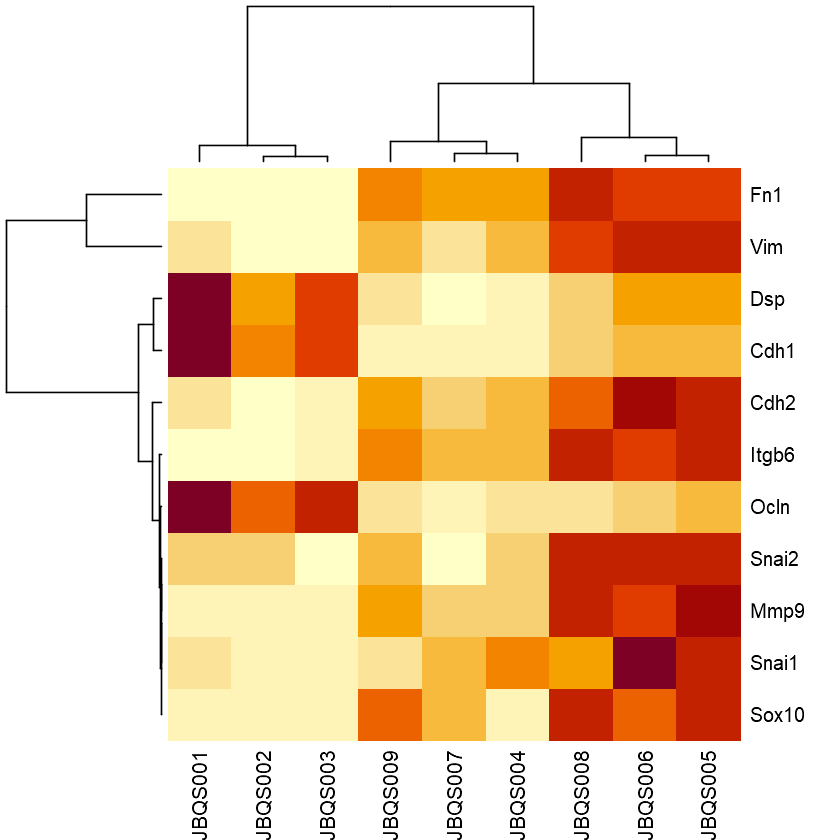

In [243]:
Exp.EMT <- na.omit(Exp.EMT)
Exp.EMT <- Exp.EMT[rowSums(Exp.EMT) >0,]
heatmap(as.matrix(Exp.EMT), scale = "row")

# Pathways score calculation based on Ribo-seq data

## Expression calling

In [244]:
#Exp <- read.table("blancgrp_211613_RNAseq_total_stranded_HTSeq.counts.raw.txt")
Exp <- read.table("blancgrp_161021_Riboseq.counts.raw.txt")
sampleTable <- factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3))
Exp <- as.data.frame(Exp)
head(Exp, 10)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
rDNA_promoter,0,0,0,0,0,0,0,0,0
rDNA_promoter1,0,0,0,0,0,0,0,0,0
0610005C13Rik,0,0,0,0,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,0,0,0,0
0610009B22Rik,32,34,28,12,12,19,35,38,31
0610009E02Rik,0,0,0,0,0,1,0,0,0
0610009L18Rik,1,0,0,0,0,0,0,3,0
0610010F05Rik,13,10,15,4,12,14,9,4,8
0610010K14Rik,16,18,29,4,3,7,12,14,27


In [245]:
STAR_FPKM <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "RAW")
STAR_FPKM <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "FPKM")
STAR_FPKM_UQ <- GDC_FPKM(mat = Exp, gene_lengths = gene.lengths, method = "FPKM-UQ")

### Select genes 


In [246]:
Selected_Gene <- function(mat, geneLength){
    gene_lengths <- geneLength
    genes <- intersect(rownames(mat), gene_lengths$Symbol)
    gene_lengths <- as.data.frame(gene_lengths[gene_lengths$Symbol%in%genes,])
    mat <- as.data.frame(mat[genes,])
  return(list(Expression=mat, GeneLength=geneLength))}


Selected_a <- Selected_Gene(mat = STAR_FPKM$FPKM, geneLength = STAR_FPKM$GeneLength)

head(Selected_a$Expression, n=10)
head(Selected_a$GeneLength, n=10)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,34.310422,32.2540982,39.1210445,26.2556529,35.2525612,28.2085913,34.017734,29.853643,28.3478859
Pbsn,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000
Cdc45,5.257838,4.8994898,5.5771767,4.5448170,4.2596312,6.9714384,5.820739,4.432337,6.3663830
H19,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000
Scml2,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000
Apoh,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000
Narf,10.410963,6.9250149,10.2785105,6.6309315,9.9437482,8.0772845,7.961732,4.957897,5.6395155
Cav2,58.827653,55.3701108,48.4480752,19.1113983,26.4204421,18.1066803,28.301273,19.880970,25.8151446
Klf6,118.147321,117.1156304,127.7337843,136.0805766,124.8206769,149.9641405,169.636576,180.489291,171.0149626


,Gene,Symbol,Chr,Start,End,Strand,GeneType,Length,exon_length,exon_number
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3,108014596,108053462,-,protein_coding,38867,3262,9
2,ENSMUSG00000000003,Pbsn,X,76881507,76897229,-,protein_coding,15723,902,9
3,ENSMUSG00000000028,Cdc45,16,18599197,18630737,-,protein_coding,31541,3506,25
4,ENSMUSG00000000031,H19,7,142129266,142131880,-,lncRNA,2615,2460,20
5,ENSMUSG00000000037,Scml2,X,159865521,160041209,+,protein_coding,175689,6397,50
6,ENSMUSG00000000049,Apoh,11,108234180,108305222,+,protein_coding,71043,1594,16
7,ENSMUSG00000000056,Narf,11,121128079,121146682,+,protein_coding,18604,4806,16
8,ENSMUSG00000000058,Cav2,6,17281184,17289114,+,protein_coding,7931,3335,7
9,ENSMUSG00000000078,Klf6,13,5911481,5920393,+,protein_coding,8913,4391,11


### Score calculation

In [247]:
S_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Gene %in% cc.S$geneID) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
G2M_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Gene %in% cc.G2$geneID) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
CCP <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% CCP_gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Housekeeping_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Housekeeping_gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Hypoxia_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Hypoxia_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Mesenchymal_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Mesenchymal_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Epithelial_Score <- Selected_a$Expression %>% filter(Selected_a$GeneLength$Symbol %in% Epithelial_Gene) %>% dplyr::select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)

Score_Total <- as.data.frame(t(rbind(S_Score, G2M_Score, CCP, Housekeeping_Score, Hypoxia_Score, Mesenchymal_Score, Epithelial_Score)))
head(Score_Total)

,S_Score,G2M_Score,CCP,Housekeeping_Score,Hypoxia_Score,Mesenchymal_Score,Epithelial_Score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.219332,6.671166,4.207076,215.8935,9.767900,0.0000000,23.44700
2,3.406634,6.566708,3.584874,197.5038,10.751936,0.5284211,27.00952
3,3.147204,6.271512,4.811376,189.6948,8.970583,0.4341735,22.37484
4,3.480587,4.975893,3.007198,133.6518,4.150178,2.6739492,21.85808
5,2.800425,4.421527,3.123051,120.6093,5.934146,4.4318467,19.32688
6,3.362612,4.517560,2.745775,113.8499,6.902531,4.0412902,25.15590


In [248]:
Mesenchymal_Score=Mesenchymal_Score-Housekeeping_Score
Epithelial_Score=Epithelial_Score-Housekeeping_Score
Score_Total <- Score_Total %>%
  dplyr::select(everything()) %>%
  mutate(EMT_Score=scales::rescale(Mesenchymal_Score-Epithelial_Score, to = c(0.1,1)), 
         CCP_Score=scales::rescale(CCP-Housekeeping_Score, to=c(0.1,1)), 
         S_Score=scales::rescale(S_Score, to = c(0.1,1)),
         G2M_Score=scales::rescale(G2M_Score, to = c(0.1,1)),
         Hypoxia_Score=scales::rescale(Hypoxia_Score, to = c(0.1,1)),
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  dplyr::select(c("Sample","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score"), everything())

Score_Total

Sample,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,0.2478658,0.1000000,1.0000000,1.0000000,0.8973325,4.207076,215.8935,0.0000000,23.44700
Control,0.1000000,0.2589811,0.6497960,0.9584690,1.0000000,3.584874,197.5038,0.5284211,27.00952
Control,0.3212771,0.3398305,0.5380039,0.8411031,0.8141459,4.811376,189.6948,0.4341735,22.37484
TGFB,0.4556158,0.8251541,0.6816636,0.3259836,0.3112180,3.007198,133.6518,2.6739492,21.85808
TGFB,0.6646439,0.9428935,0.3885713,0.1055758,0.4973449,3.123051,120.6093,4.4318467,19.32688
TGFB,0.3615343,1.0000000,0.6308261,0.1437572,0.5983796,2.745775,113.8499,4.0412902,25.15590
TGFb_CX5461,1.0000000,0.4805401,0.1000000,0.4976140,0.3474623,2.053722,171.2117,2.1540610,10.16784
TGFb_CX5461,0.9076637,0.7641746,0.5234384,0.1000000,0.1000000,2.725117,140.1846,3.4985415,13.40699
TGFb_CX5461,0.9149219,0.4766884,0.3556430,0.3530672,0.1989667,2.770957,172.3594,1.4646309,11.22415


In [317]:
Mesenchymal_Score=Mesenchymal_Score
Epithelial_Score=Epithelial_Score
Score_Total <- Score_Total %>%
  dplyr::select(everything()) %>%
  mutate(Epithelial=scales::rescale(Epithelial_Score, to = c(0.1,1)),
         Mesenchymal=scales::rescale(Mesenchymal_Score, to = c(0.1,1)),
         EMT_Score=scales::rescale(Mesenchymal-Epithelial, to = c(0.1,1)), 
         CCP_Score=scales::rescale(CCP, to=c(0.1,1)), 
         S_Score=scales::rescale(S_Score, to = c(0.1,1)),
         G2M_Score=scales::rescale(G2M_Score, to = c(0.1,1)),
         Hypoxia_Score=scales::rescale(Hypoxia_Score, to = c(0.1,1)),
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  dplyr::select(c("Sample","Epithelial","Mesenchymal","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score"), everything())

Score_Total

Sample,Epithelial,Mesenchymal,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,Ribosome_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,0.8096232,0.1000000,0.1562083,0.8027782,0.1000000,0.1000000,0.1000000,0.1000000,4.207076,215.8935,0.0000000,23.44700
Control,1.0000000,0.2073094,0.1000000,0.5997134,0.2592768,0.2634563,0.2689030,0.2595965,3.584874,197.5038,0.5284211,27.00952
Control,0.7523277,0.1881700,0.2546390,1.0000000,0.3272924,0.3317493,0.3307904,0.3371274,4.811376,189.6948,0.4341735,22.37484
TGFB,0.7247130,0.6430139,0.5810994,0.4111807,0.8251385,0.8255324,0.8105549,0.8211737,3.007198,133.6518,2.6739492,21.85808
TGFB,0.5894486,1.0000000,0.9141856,0.4489909,0.9376429,0.9393200,0.9352036,0.9455365,3.123051,120.6093,4.4318467,19.32688
TGFB,0.9009448,0.9206875,0.6497410,0.3258615,1.0000000,1.0000000,1.0000000,1.0000000,2.745775,113.8499,4.0412902,25.15590
TGFb_CX5461,0.1000000,0.5374373,0.9323782,0.1000000,0.4864948,0.4926539,0.4761219,0.4916989,2.053722,171.2117,2.1540610,10.16784
TGFb_CX5461,0.2730965,0.8104685,1.0000000,0.3191196,0.7656512,0.7647663,0.7430613,0.7743679,2.725117,140.1846,3.4985415,13.40699
TGFb_CX5461,0.1564479,0.3974308,0.7994454,0.3340800,0.4789569,0.4808031,0.4594895,0.4688008,2.770957,172.3594,1.4646309,11.22415


### Heatmap plot

In [249]:
Exp.EMT <- Exp[stringr::str_to_sentence(c("VIM", "CDH2", "FOXC2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGB6", "MMP2", "MMP3", "MMP9", "SOX10", "GCS", "CDH1", "DSP", "OCLN")),]

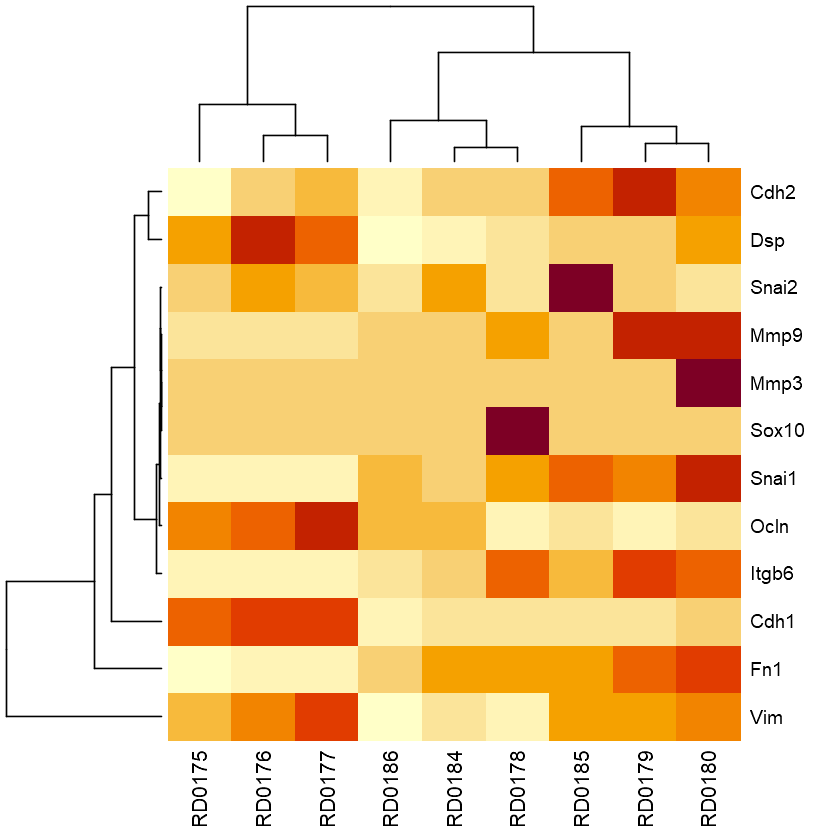

In [250]:
Exp.EMT <- na.omit(Exp.EMT)
Exp.EMT <- Exp.EMT[rowSums(Exp.EMT) >0,]
heatmap(as.matrix(Exp.EMT), scale = "row")

In [287]:
cc.s_gene <- rownames(Selected_a$Expression[Selected_a$GeneLength$Gene %in% cc.S$geneID,])
cc.G2_gene <- rownames(Selected_a$Expression[Selected_a$GeneLength$Gene %in% cc.G2$geneID,])

In [350]:
cat("House keeping genes :: ")
round(rowMeans(Exp[Housekeeping_gene,]))
cat("S phase :: ")
round(rowMeans(Exp[cc.s_gene,]))
cat("G2 Phase :: ")
round(rowMeans(Exp[cc.G2_gene,]))
cat("CCP genes :: ")
round(rowMeans(Exp[CCP_gene,]))
cat("Hypoxia genes :: ")
round(rowMeans(Exp[Hypoxia_Gene,]))
cat("Mesenchymal genes :: ")
round(rowMeans(Exp[Mesenchymal_Gene,]))
cat("Epithelial genes :: ")
round(rowMeans(Exp[Epithelial_Gene,]))
cat("Stem cell marker genes :: ")
round(rowMeans(Exp[STEM_Gene,]))
cat("Ribosome biogenesis genes :: ")
round(rowMeans(Exp[Ribosome_Gene,]))

House keeping genes :: 

Rpl38   Uba52   Psmc1    Rpl4   Rpl37   Rps29 Slc25a3    Cltc   Txnl1   Psma1 
   1275    2912     662    5255    1887    2361    2924    2935     687     415 
   Rpl8  Mmadhc  Rpl13a  Ppp2ca  Mrfap1 
   6784     270    4411    1036    1730

S phase :: 

Cdc45    Uhrf1     Mcm2     Slbp     Mcm5    Pola1     Gmnn     Cdc6 
      92      987      821      151      519       86       65      126 
    Rrm2    Atad2    Dscc1     Mcm4   Chaf1b     Rfc2     Msh2     Fen1 
     470      273       13      476      219      191      260      312 
   Hells    Prim1     Tyms     Mcm6    Wdr76    Rad51     Pcna    Ccne2 
     230       95      210      793       99      161      936       36 
Casp8ap2     Usp1     Nasp     Rpa2      Ung Rad51ap1      Blm    Pold3 
      49      113      166       92       40       26       60       93 
    Rrm1    Cenpu    Gins2    Tipin    Brip1      Dtl     Exo1     Ubr7 
     756       20       81      102       35      100       66      200 
   Clspn     E2f8    Cdca7 
      59      104      144

G2 Phase :: 

Ube2c     Lbr    Ctcf   Cdc20    Cbx5   Kif11  Anp32e   Birc5    Cdk1    Tmpo 
    353     349     252     241    1727     207     259     193     412     790 
   Hmmr    Jpt1  Pimreg   Aurkb   Top2a   Gtse1 Rangap1   Cdca3   Ndc80  Kif20b 
     94    1402     161     170     801     244    1253     174      64     128 
  Cenpf    Nek2    Nuf2  Nusap1    Bub1    Tpx2   Aurka    Ect2   Cks1b   Kif2c 
    189     220      67     101      98     515     378     338     300     110 
  Cdca8   Cenpa   Mki67   Ccnb2   Kif23    Smc4    G2e3  Tubb4b    Anln   Tacc3 
    131     185     573     206     259     213      74    2580     497     335 
 Dlgap5   Ckap2  Ncapd2     Ttk   Ckap5  Cdc25c   Hjurp   Cenpe  Ckap2l   Cdca2 
    106     120     371      47     399      54     621     141     152      96 
  Hmgb2    Cks2   Psrc1  Gas2l3 
    186     150     140      91

CCP genes :: 

Plk1   Rrm2  Cdca8  Cdc20  Cdca3  Foxm1  Birc5    Pbk  Cdkn3  Cenpm  Mcm10 
   327    470    131    241    174    421    193     56     15     39    159 
   Tk1    Dtl  Asf1b Nusap1   Prc1  Bub1b Dlgap5  Top2a   Aspm  Cenpf Kif20a 
   198    100    122    101    354    567    106    801    139    189    514 
 Pttg1 Rad54l   Orc6   Cdk1  Cep55  Kif11  Rad51     NA   Ska1 
    70     44    110    412     92    207    161     NA     28

Hypoxia genes :: 

Bnip3      F3     Lox     Tnf      Th  Slc2a1    Pgk1   Ndrg1     Gal  Bnip3l 
     69     780       0       0       0     308    4576    1547       0     368 
    Ang   P4ha1     Adm     Ak3    Pdk1      NA   Aldoc   Plod2   P4ha2    Mxi1 
      0     133       0    1295     107      NA      38     159      20      78 
  Ddit4 Angptl4 
    444      27

Mesenchymal genes :: 

Vim   Cdh2  Foxc2  Snai1  Snai2 Twist1    Fn1  Itgb6   Mmp2   Mmp3   Mmp9 
 12929   1301      0      7      6      0  18335    312      0      0      4 
 Sox10     NA 
     1     NA

Epithelial genes :: 

Cdh1  Dsp Ocln 
2053 3139  124

Stem cell marker genes :: 

Dnmt3b    Pfas   Xrcc5   Haus6    Tet1 Igf2bp1    Plaa   Tex10    Msh6  Dlgap5 
      8     456     198      74       0     793     167     164     415     106 
     NA  Sohlh2   Rras2   Paics   Cpsf3  Lin28b    Ipo5  Bmpr1a    NA.1   Ascc3 
     NA       0     410     728     261       0    1135     167      NA     148 
  Fancb   Hmga2  Trim24    Orc1   Hdac2   Hesx1   Inhbe  Mis18a Dcun1d5   Mrpl3 
     19     665     104      32     221       0       0      70     203     178 
  Cenph    Mycn   Haus1    Gdf3    Tbce   Riok2  Bckdhb    Rad1    Nrep    Adh5 
     28       0      37       0      62      87      48      46      77     561 
  Plrg1    Ror1   Rab3b  Diaph3    Gnl2    Fgf2  Nmnat2  Kif20a   Cenpi    Ddx1 
    237      81      43      88     112       0       5     514      69     434 
 Xxylt1  Gpr176    Bbs9    NA.2    Bod1  Cdc123  Snrpd3 Fam118b    Dph3  Eif2b3 
     99       0      42      NA     169     239     258     135      95      57 
   Rpf2   Aplp1   Dact1    Pdhb    NA.3    Dtd1  Samm50   Ccl26   Med20    Utp6 
     52      28       0     217      NA      55     729       0     213     200 
  Rars2  Armcx2    Rars  Mthfd2   Dhx15    Htr7 Mthfd1l   Armc9    Xpot    Iars 
     34       0     460     321     456       0     241     201     524    1383 
    Hdx  Actrt3   Ercc2 Tbc1d16    Gars    Kif7   Ube2k Slc25a3    Icmt   Uggt2 
      0       0     229     216    1640      22     313    2924     419      11 
 Atp11c Slc24a1 Eif2ak4    Gpx8    Alx1    Ostc   Trpc4    Has2    Fzd2   Trnt1 
     46       0     204      21       0     290       0       0     386     114 
 Mmadhc    Snx8    Cdh6    Hat1  Sec11a   Dimt1   Tm2d2     Fst    Gbe1 
    270     407    1551     148     279      52     266      48      27

Ribosome biogenesis genes :: 

Myc    Heatr1   Dnttip2    Ddx19b      Rpl3        NA     Rps28      NA.1 
      446       424       152       130      5055        NA      3107        NA 
    Rpl19    Eif4a3    Polr2e     Ddx56     Rps4x      Rps6      Rps8      NA.2 
     4578       545       335       334      5908      2672      2400        NA 
    Rps14     Nol11     Rps24     Wbp11      Rps5      Rps7      Mdn1     Rps16 
     2064       231      1915       420      2639      1738       279      3522 
     Esf1     Rpl18     Rpl26     Rpl17      Rrn3      Rps9     Rplp2     Rps13 
       86      2864      1078      2781       483      4174      3552      2242 
     Rpl8     Kif11    Rpl35a    Rpl23a     Rpl24     Bccip      Rpl7     Rps11 
     6784       207      1510      2762      2190       173      3766      2716 
    Nop56      Utp4    Rps15a     Rpp30    Exosc9     Riox2     Rps10     Numa1 
     1108       275      2318        93        85        36      3620      1821 
Mphosph10      Nsa2   Trmt112     Rps21     Nop58     Utp20    Rpusd2      Rrs1 
       60       386       542      2295       294       467        83       196 
   Nudt16     Nolc1      Nol8   Mettl15   Suv39h1     Xrcc5     Abce1      Ttf1 
        6       853        64        10       291       198       407       101 
  Mpv17l2      Maf1    Polr1d     Taf1d 
      175       385       369      1514

In [340]:
library(clusterSim)

Warning message:
"package 'clusterSim' was built under R version 4.1.2"
Loading required package: cluster

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:dplyr':

    select




In [342]:
scale(Selected_a$Expression)[1:5,1:6]

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006
Gnai3,-2.434488e-05,0.0008565482,0.0004023277,-0.001514230,0.0005347329,0.0002619053
Pbsn,-5.924163e-03,-0.0058116087,-0.0059207954,-0.005847453,-0.0063173986,-0.0062336410
Cdc45,-4.496449e-03,-0.0044470280,-0.0042629034,-0.004941415,-0.0049828591,-0.0050395310
H19,-5.924163e-03,-0.0058116087,-0.0058950916,-0.005847453,-0.0063173986,-0.0062233469
Scml2,-5.924163e-03,-0.0058116087,-0.0059079435,-0.005847453,-0.0063173986,-0.0062336410


In [349]:
data.Normalization(Selected_a$Expression, type = "n1", normalization = "column")

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,-2.434488e-05,8.565482e-04,0.0004023277,-1.514230e-03,0.0005347329,0.0002619053,-0.0015739715,-4.945217e-04,-0.0006926530
Pbsn,-5.924163e-03,-5.811609e-03,-0.0059207954,-5.847453e-03,-0.0063173986,-0.0062336410,-0.0058312494,-6.190571e-03,-0.0060017281
Cdc45,-4.496449e-03,-4.447028e-03,-0.0042629034,-4.941415e-03,-0.0049828591,-0.0050395310,-0.0051441098,-5.446643e-03,-0.0053331779
H19,-5.924163e-03,-5.811609e-03,-0.0058950916,-5.847453e-03,-0.0063173986,-0.0062233469,-0.0058163116,-6.190571e-03,-0.0059886192
Scml2,-5.924163e-03,-5.811609e-03,-0.0059079435,-5.847453e-03,-0.0063173986,-0.0062336410,-0.0058312494,-6.179468e-03,-0.0060017281
Apoh,-5.924163e-03,-5.811609e-03,-0.0059207954,-5.834322e-03,-0.0062725402,-0.0062336410,-0.0058312494,-6.179468e-03,-0.0060017281
Narf,-2.029443e-03,-2.196173e-03,-0.0016925281,-4.311128e-03,-0.0038726119,-0.0042468891,-0.0040984626,-4.169751e-03,-0.0040354040
Cav2,1.130424e-03,2.192993e-03,0.0022787016,-2.866721e-03,-0.0015063275,-0.0006851474,-0.0018279144,-6.832797e-04,-0.0014529650
Klf6,-1.818133e-04,-5.786147e-05,-0.0001117474,5.615891e-03,0.0088559795,0.0077662686,0.0064924499,7.588761e-03,0.0083786554
